<a href="https://colab.research.google.com/github/amirkasaei/Intelligent-Analysis-of-Biomedical-Images/blob/main/HW/HW1/Prac/Classic_Processing_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
Classic methods
</font>

## Imoports and installs

In [ ]:
!pip install pydicom -q

In [ ]:
import numpy as np
from pydicom import dcmread
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d

## load and work with DICOM

function `load_I` recives the file name and loads the provided DICOM file, prints its content and returns the image in it.

In [ ]:
!git clone https://github.com/amirkasaei/Intelligent-Analysis-of-Biomedical-Images.git

fatal: destination path 'Intelligent-Analysis-of-Biomedical-Images' already exists and is not an empty directory.


In [ ]:
path = '/content/Intelligent-Analysis-of-Biomedical-Images/SPB_HW1/'

In [ ]:
def load_I(name):
  ds = dcmread(path + name)
  print(ds)
  pa = ds.pixel_array
  return pa

I=load_I("img.dcm")

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.1055.1.20111103112244831.30826609.78057758
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.1055.1
(0002, 0013) Implementation Version Name         SH: 'dicomlibrary-100'
(0002, 0016) Source Application Entity Title     AE: 'DICOMLIBRARY'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 182
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'SECONDARY', 'OTHER', 'ARC', 'DICOM', 'VALIDATION']
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.1055

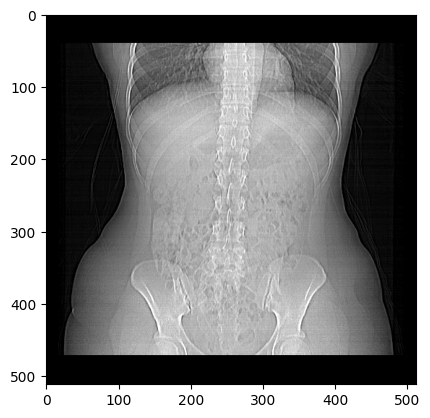

In [ ]:
plt.imshow(I, cmap="gray")
plt.show()

The cell below, adds some noise to the original image

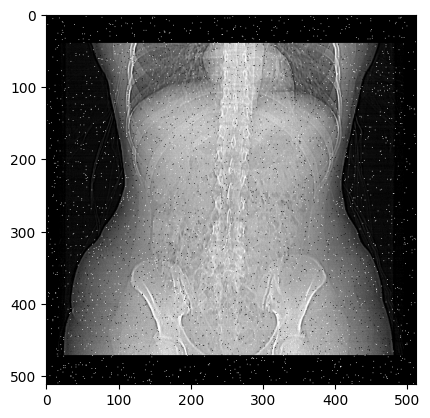

In [ ]:
def add_salt_and_pepper_noise(image, noise_ratio=0.02):
    noisy_image = image.copy()
    h, w= noisy_image.shape
    noisy_pixels = int(h * w * noise_ratio)

    for _ in range(noisy_pixels):
        row, col = np.random.randint(0, h), np.random.randint(0, w)
        if np.random.rand() < 0.5:
            noisy_image[row, col] = 0
        else:
            noisy_image[row, col] = 255

    return noisy_image

I=add_salt_and_pepper_noise(I)
plt.imshow(I, cmap="gray")
plt.show()

## Deniosing

In last section we added some noise to the original image, now you are expected to denoise the noisy image using two diffrent approaches.
1. frequency filter for denoising (low pass filter)
2. spatial filter that can reduce the noise


### 1) denoising using frequency filters


In [ ]:
def low_pass(I):
  # convert to frequncy domain using fourier transform
  f = np.fft.fft2(I)

  # shift the zero-frequency component to the center of the spectrum
  f_shift = np.fft.fftshift(f)

  # create white circle mask on black background and invert so black circle on white background
  radius = 60
  lim = 80
  mask = np.zeros_like(I)
  cy = mask.shape[0] // 2
  cx = mask.shape[1] // 2
  # cv2.circle(mask, (cx,cy), radius, (1,1,1), -1)[0]
  cv2.rectangle(mask, (cx-lim, cy-lim), (cx+lim, cy+lim), color=(1,1,1), thickness=-1)

  # apply mask to dft_shift
  f_shift_masked = np.multiply(f_shift, mask)

  # converts back to space domain
  f_ishift = np.fft.ifftshift(f_shift_masked)
  f_back = np.fft.ifft2(f_ishift)
  f_back = np.real(f_back)

  return f_back


I_df=low_pass(I)

Text(0.5, 1.0, 'Low Pass Filter')

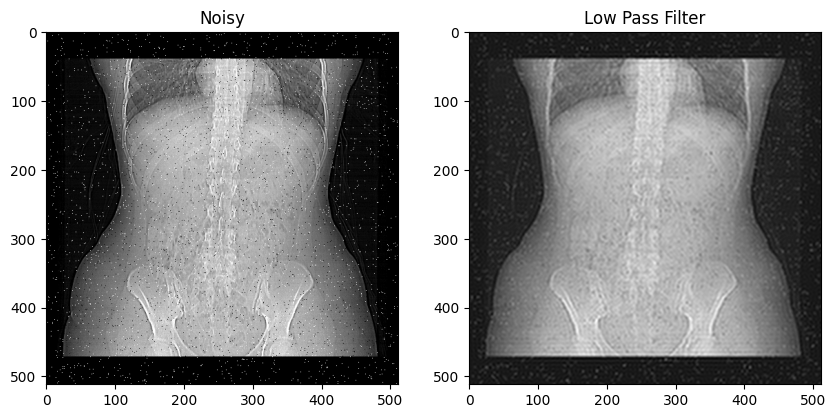

In [ ]:
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(I, cmap = 'gray')
arr[0].set_title('Noisy')
arr[1].imshow(I_df, cmap = 'gray')
arr[1].set_title('Low Pass Filter')

### 2) denoising using spatial filters

In [ ]:
def denoise_spatial(I):

  # filter = np.ones((5, 5)) / 25

  # I_blur = cv2.filter2D(I, -1, filter)

  I_blur = cv2.medianBlur(I,5)

  return I_blur

I_ds=denoise_spatial(I)

Text(0.5, 1.0, 'denoise_spatial')

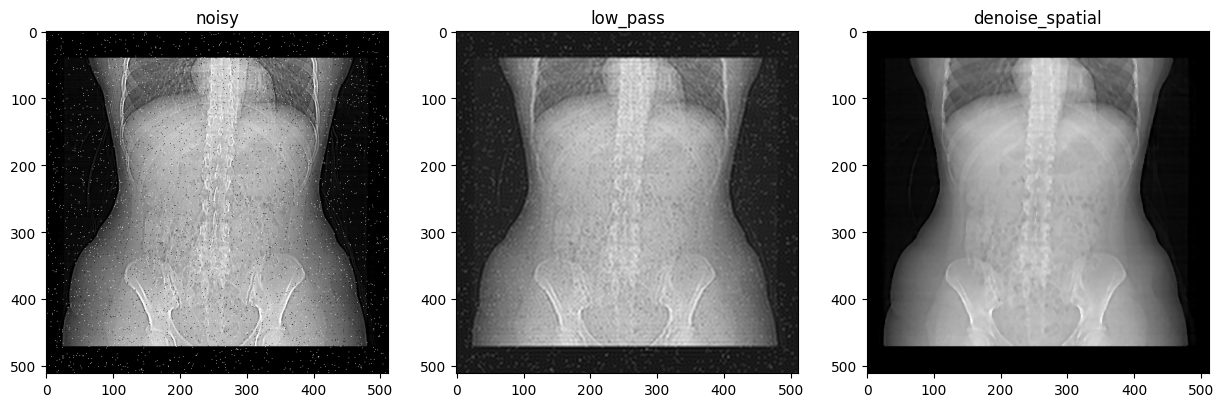

In [ ]:
fig, arr = plt.subplots(1, 3, figsize=(15, 15))
arr[0].imshow(I, cmap = 'gray')
arr[0].set_title('noisy')
arr[1].imshow(I_df, cmap = 'gray')
arr[1].set_title('low_pass')
arr[2].imshow(I_ds, cmap = 'gray')
arr[2].set_title('denoise_spatial')

A spatial median filter (which used as a smoothing spatial filter) is a nonlinear filter that replaces the value of a pixel with the median value of its neighboring pixels. It is commonly used to remove salt-and-pepper noise from images.

On the other hand, a low-pass filter in Fourier space is used to remove high-frequency components from an image. It is also known as a smoothing filter and is used to blur an image.

So in our case with salt and pepper noise in the image, spatial median filter is a better choice, as we can see the resluts in denoising

In [ ]:
I=I_ds
#I=I_df

## Global Sharpening

Denoising images usualy result in less detailed blury images, therfore it is desirable to sharpen the denoised image.
for this means we have to amplify image details by first extracting them and then adding them to the image.


### 1) sharpening using high pass filter

In [ ]:
def high_pass(I):
  # convert to frequncy domain using fourier transform
  f = np.fft.fft2(I)

  # shift the zero-frequency component to the center of the spectrum
  f_shift = np.fft.fftshift(f)

  # create white circle mask on black background and invert so black circle on white background
  radius = 50
  lim = 50
  mask = np.ones_like(I)
  cy = mask.shape[0] // 2
  cx = mask.shape[1] // 2
  # cv2.circle(mask, (cx,cy), radius, (0,0,0), -1)[0]
  cv2.rectangle(mask, (cx-lim, cy-lim), (cx+lim, cy+lim), color=(0,0,0), thickness=-1)

  # # apply mask to dft_shift
  f_shift_masked = np.multiply(f_shift, mask)

  # converts back to space domain
  f_ishift = np.fft.ifftshift(f_shift_masked)
  f_back = np.fft.ifft2(f_ishift)
  f_back = np.real(f_back)

  return f_back


detail_I = high_pass(I)
I_sharp_hi=I+detail_I

Text(0.5, 1.0, 'High Pass Filter')

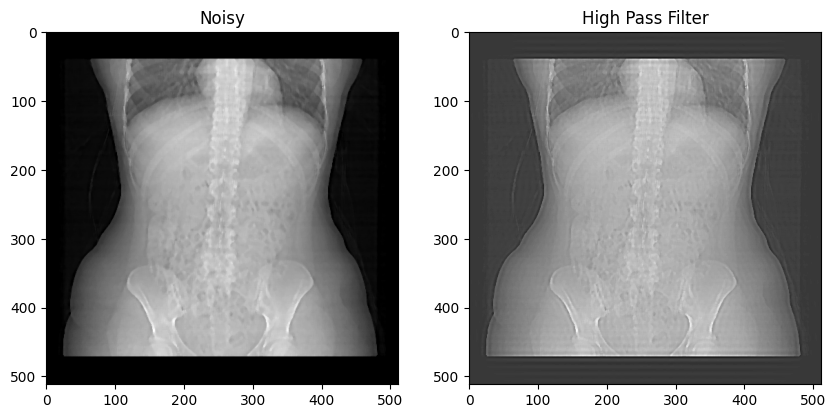

In [ ]:
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(I, cmap = 'gray')
arr[0].set_title('Noisy')
arr[1].imshow(I_sharp_hi, cmap = 'gray')
arr[1].set_title('High Pass Filter')

### 2) sharpening using a spatial filter

In [ ]:
def detail_spatial(I):

  filter = np.array([[2, 1, 0],
                     [1, 0, -1],
                     [0, -1, -2]])

  # I_sharp = convolve2d(I, filter, 'same')
  I_sharp = cv2.filter2D(I, -1, filter)

  return I_sharp / 3

detail_I = detail_spatial(I)
I_sharp_spatial= I + detail_I

Text(0.5, 1.0, 'I_sharp_spatial')

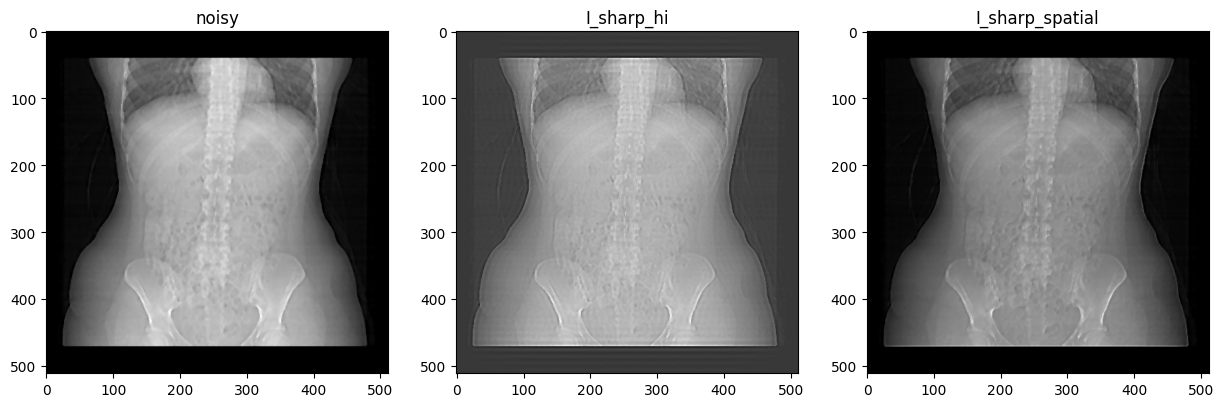

In [ ]:
fig, arr = plt.subplots(1, 3, figsize=(15, 15))
arr[0].imshow(I, cmap = 'gray')
arr[0].set_title('noisy')
arr[1].imshow(I_sharp_hi, cmap = 'gray')
arr[1].set_title('I_sharp_hi')
arr[2].imshow(I_sharp_spatial, cmap = 'gray')
arr[2].set_title('I_sharp_spatial')

## Multi-scale image enhancement

In [ ]:
def global_enhancement(I):
    return(np.tanh(I/16) * max(np.max(I), np.abs(np.min(I))))

In [ ]:
def up_sample_blur(I):
    I_e = cv2.pyrUp(I)

    return(I_e)

def down_sample(I):
    I_d = cv2.pyrDown(I)

    return(I_d)

def image_pyramid(I, n_levels):
    lst = []

    I = np.float32(I)

    for i in range(0, n_levels):
        I_d = down_sample(I)
        D = I - up_sample_blur(I_d)
        lst.append(D)

        I = I_d

    lst.append(I)

    return(lst)

def image_pyramid_rec(lst, n_levels):

    I = lst[n_levels]

    for i in range(n_levels, 0, -1):
        I = up_sample_blur(I) + lst[i-1]

    return(I)

Text(0.5, 1.0, 'I_e')

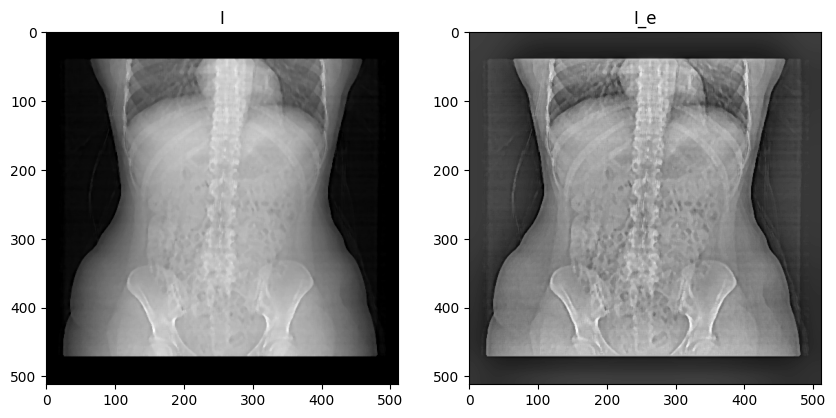

In [ ]:
def multi_enhance(I, n_levels):
  prm = image_pyramid(I, n_levels)

  for i in range(n_levels):
      prm[i] = global_enhancement(prm[i])

  I_pr = image_pyramid_rec(prm, n_levels)
  I_pr -= np.min(I_pr)
  return I_pr


I_e=multi_enhance(I, 5)



fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(I, cmap = 'gray')
arr[0].set_title('I')
arr[1].imshow(I_e, cmap = 'gray')
arr[1].set_title('I_e')

## Gray level enhancment

Text(0.5, 1.0, 'I_c')

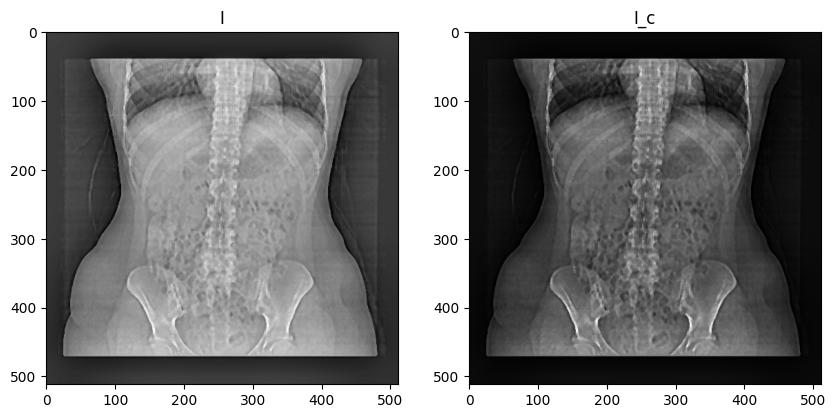

In [ ]:
def gray_enhance(I):

  #Image Negatives (Linear)
  # I_neg = cv2.bitwise_not(I)

  # Log Transformations
  # c = np.max(I) / np.log(1 + np.max(I))
  # I_log =  c * (np.log(I + 1))
  # # specify the data type so that float value will be converted into int
  # I_log = np.array(I_log, dtype = np.uint8)

  # Power-Law (Gamma) Transformations
  gamma = 2.0
  I_power = (np.power(I, gamma)).astype(float)
  I_power /= np.max(I_power)

  return I_power

I_c = gray_enhance(I_e)

fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(I_e, cmap = 'gray')
arr[0].set_title('I')
arr[1].imshow(I_c, cmap = 'gray')
arr[1].set_title('I_c')